# Titanic!

In [1]:
EVAL = False

## Preparation

### Imports

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier  
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

### Loading data

In [3]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Investigation

### NA's

In [4]:
if EVAL:
    null_counts = [(column, null_count) for column in data.columns.values if (null_count := sum(data[column].isna())) > 0]
    plt.bar(*list(zip(*null_counts)))

    plt.axhline(len(data), color = 'green', label= "Total")
    plt.title("Columns with >0 NA count")
    plt.legend()

    plt.show()

In [5]:
data = data.drop(columns='Cabin')
data = data.dropna(ignore_index=True)

### Categoricals

In [6]:
cat_cols = [ 'Pclass', 'Sex', 'Embarked']

In [7]:
def plot_categoricals(column): 
    categories = data[column].unique()

    survived_counts = []
    perished_counts = []
    survived_pcts = []
    perished_pcts = []
    for cat in categories:
        category_data = data[data[column] == cat]
        total = len(category_data)

        survived_count = len(category_data[category_data['Survived'] == 1])
        survived_counts.append(survived_count)

        perished_count = total - survived_count
        perished_counts.append(perished_count)

        survived_pcts.append(f'{survived_count / total:.1%}')
        perished_pcts.append(f'{perished_count / total:.1%}')

    fig, ax = plt.subplots()
    ax.bar(categories, survived_counts, color = "green", label = "Survived")
    ax.bar(categories, perished_counts, bottom=survived_counts, color = "red", label = "Perished")
    ax.set_title(f"Survivors by {column}")
    ax.bar_label(ax.containers[0], survived_pcts, label_type='center')
    ax.bar_label(ax.containers[1], perished_pcts, label_type='center')
    ax.legend()

In [8]:
if EVAL: 
    for col in cat_cols: 
        plot_categoricals(col)

### Continuous

In [9]:
cont_cols = ['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare']

In [10]:
def plot_continuous(column):
    survived = data[column][data['Survived'] == 1]
    perished = data[column][data['Survived'] == 0]
    plt.hist([survived, perished], 10, color=['green', 'red'], label=['Survived', 'Perished'])
    plt.title(f"Survivors by {column}")
    plt.legend()
    plt.show()

In [11]:
if EVAL:
    for col in cont_cols:
        plot_continuous(col)

## Data Preperation

### Functions

In [12]:
# helper function adapted from lecture examples

# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - get precision, recall, f1 for test data
# this has simply been created as we're going to do this for each test that we run 
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[12, 6])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance: %1.3f' % (sum(model.predict(X_train) == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Testing Set Performance: %1.3f' % (sum(model.predict(X_test) == Y_test)/len(Y_test)));
    print(classification_report(Y_test, model.predict(X_test)))

### Categoricals to numeric

In [13]:
def process_categoricals(df):
    df = df.drop(columns=['Name', 'Ticket'])

    translator_sex = {
        'male': 0,
        'female': 1
    }
    df['Sex'] = df['Sex'].map(lambda x: translator_sex[x])

    translator_embarked = {
        'C': 0,
        'Q': 1,
        'S': 2,
    }
    df['Embarked'] = df['Embarked'].map(lambda x: translator_embarked[x])


    one_hot_embarked = np.eye(3)[np.array(df['Embarked'])]
    embarked_df = pd.DataFrame(one_hot_embarked, columns=translator_embarked.keys())
    df = df.join(embarked_df)

    df = df.drop(columns='Embarked')
    return df

In [14]:
data = process_categoricals(data)

In [15]:
if EVAL:
    data.head()

### Data Split

In [16]:
y = 'Survived'

y_data = data[y]
x_data = data.drop(columns=[y, 'PassengerId'])

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size= 0.3, random_state= 1)


### Normalization

In [17]:
if EVAL:
    x_train.boxplot()

In [18]:
mu = np.mean(x_train, axis=0)
sigma = np.std(x_train, axis=0)
x_train = (x_train - mu) / sigma;
x_test = (x_test - mu) / sigma;

In [19]:
if EVAL:
    x_train.boxplot()

## Models

### SVM

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       126
           1       0.79      0.75      0.77        88

    accuracy                           0.81       214
   macro avg       0.81      0.80      0.81       214
weighted avg       0.81      0.81      0.81       214



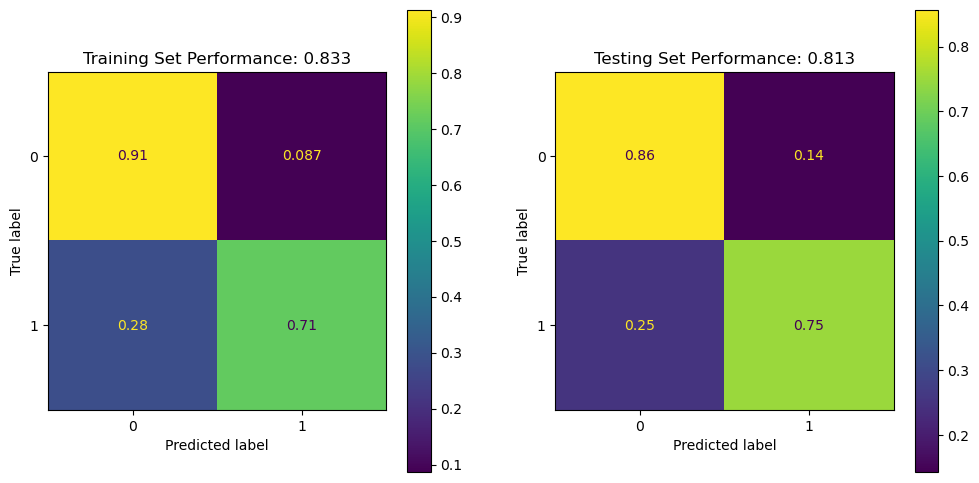

In [20]:
svm = SVC(C=1, kernel='rbf', gamma=0.1)
svm.fit(x_train, y_train)
eval_model(svm, x_train, y_train, x_test, y_test)

### CKNN

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       126
           1       0.73      0.75      0.74        88

    accuracy                           0.79       214
   macro avg       0.78      0.78      0.78       214
weighted avg       0.79      0.79      0.79       214



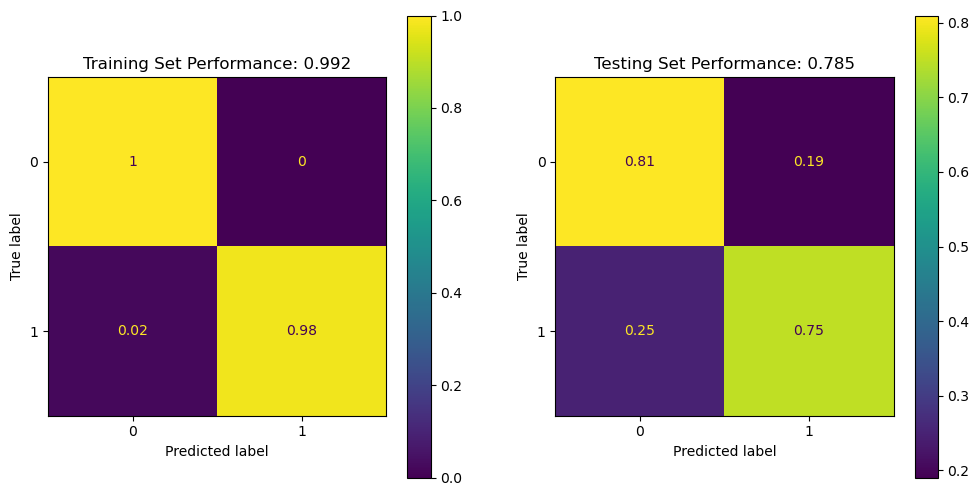

In [21]:
cknn = KNeighborsClassifier(n_neighbors=5, weights='distance')
cknn.fit(x_train, y_train)
eval_model(cknn, x_train, y_train, x_test, y_test)

### Random Forest

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       126
           1       0.85      0.62      0.72        88

    accuracy                           0.80       214
   macro avg       0.81      0.77      0.78       214
weighted avg       0.81      0.80      0.79       214



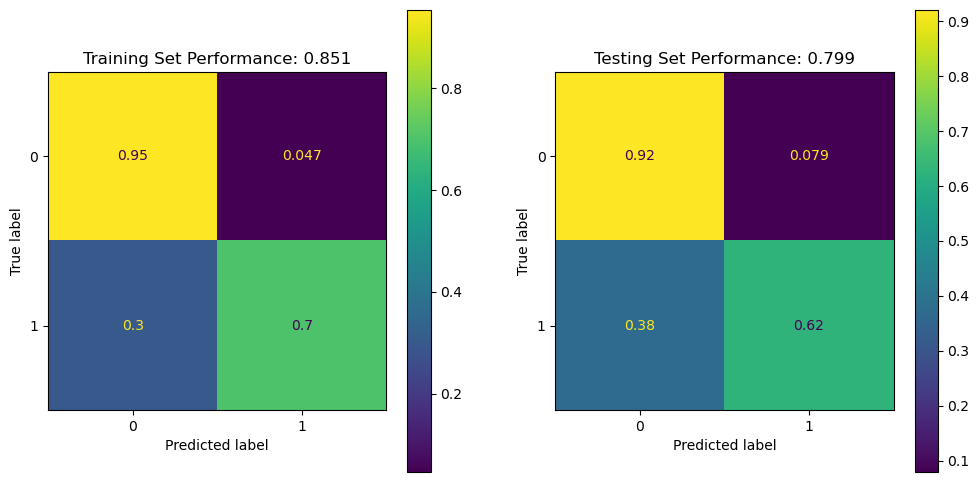

In [22]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
rf.fit(x_train, y_train)
eval_model(rf, x_train, y_train, x_test, y_test)

## Results

In [34]:
res_data = pd.read_csv('test.csv')

In [35]:
res_data = process_categoricals(res_data)
res_data = res_data.drop(columns='Cabin')
res_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,892,3,0,34.5,0,0,7.8292,0.0,1.0,0.0
1,893,3,1,47.0,1,0,7.0000,0.0,0.0,1.0
2,894,2,0,62.0,0,0,9.6875,0.0,1.0,0.0
3,895,3,0,27.0,0,0,8.6625,0.0,0.0,1.0
4,896,3,1,22.0,1,1,12.2875,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,0,NaN,0,0,8.0500,0.0,0.0,1.0
414,1306,1,1,39.0,0,0,108.9000,1.0,0.0,0.0
415,1307,3,0,38.5,0,0,7.2500,0.0,0.0,1.0
416,1308,3,0,NaN,0,0,8.0500,0.0,0.0,1.0


In [38]:
x_res = data.drop(columns=[y, 'PassengerId'])
x_res = (x_res - mu) / sigma;

prediction = svm.predict(x_res)

In [40]:
results = pd.concat([data['PassengerId'], pd.DataFrame(prediction, columns=['Survied'])], axis=1)
results.to_csv('results.csv', index=False)